In [1]:
name = '2015-01-22-satviewer'
title = "Satellite imagery viewer in Python"
tags = 'python, dataviz, meteorology, polar lows'

In [2]:
from nb_tools import connect_notebook_to_post
from IPython.core.display import HTML

html = connect_notebook_to_post(name, title, tags)

**Task:** read a GeoTiff satellite image, place it on a map, make the plot interactive

**Tools:** Python 2.7.6, matplotlib 1.3.1, Basemap, osgeo.gdal

## Preamble

My current work involves analysing meteorological data for a particular polar low, observed over the Norwegian Sea during the [ACCACIA](http://arcticaccacia.wordpress.com/) field campaign. To get a bigger picture of synoptic circulation that prevailed before and during the polar low event, I decided to look at the satellite imagery.

In [3]:
%matplotlib inline

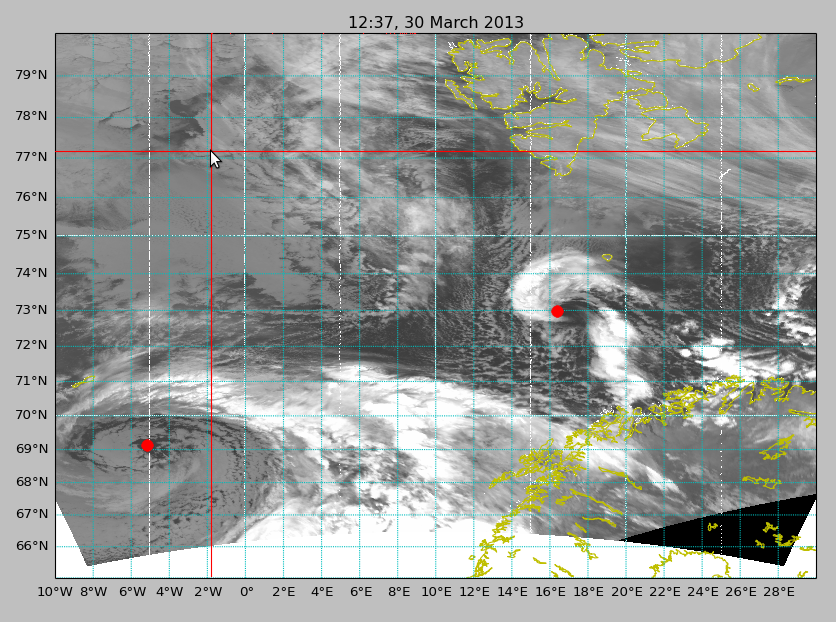

In [4]:
from IPython.core.display import Image
Image('../figures/satviewpy_screenshot.png', retina=True)

What I wanted to do is not just a slideshow, but an interface that correctly places a satellite image on a given map projection and then allows one to pinpoint a dot on the map and stores the coordinates of the dot in a text file.

## Solution

Although I'm not totally satisfied with how I wrote the interface and I never properly tested it, it works perfectly enough for my needs. The thing that I keep referring to as 'interface' is actually a callable Python object (class under an ingenious name **SatView**). It wraps all the functions to read an image, fiddle with its projection, and make a plot with a connection to user actions, namely to which mouse buttons user presses and where at that time the mouse is located relative to the plot coordinates.

Once called with a given list of file names, this object creates a figure and sets up a map using the Matplotlib's `Basemap` class. This is pretty straightforward, and comments could be of help. For those who are not familiar with [OOP](http://www.tutorialspoint.com/python/python_classes_objects.htm), `self` constantly appearing in the code is the object instance.

In [5]:
def __call__(self,lon1=-180.,lon2=180.,lat1=-90.,lat2=90.,proj='mill',tick_incr=[1,1]):
    self.fig = plt.figure() # Create a figure
    self.ax = self.fig.add_subplot(111) # Define axes

    # Set up map with intermediate coastline resolution
    self.bm = Basemap(projection=proj,llcrnrlon=lon1,llcrnrlat=lat1, \
                      urcrnrlon=lon2,urcrnrlat=lat2, \
                      resolution='i')
    # Assign coordinate lines frequency
    ticklon = np.array(tick_incr)[0]
    try:
        # Check if two numbers are given for x and y axes separately
        ticklat = np.array(tick_incr)[1]
    except IndexError:
        # If not, assume that coordinate lines only for x axis are given
        ticklat = ticklon

    # Draw parallels and meridians in cyan color with given frequency
    self.bm.drawmeridians(np.arange(round(lon1),lon2,ticklon),labels=[0,0,0,1],color='c')
    self.bm.drawparallels(np.arange(round(lat1),lat2,ticklat),labels=[1,0,0,0],color='c')
    # Draw coastlines in yellow
    self.bm.drawcoastlines(color='y')
    # Then other functions are called...

The default projection is [Miller Cylindrical](http://matplotlib.org/basemap/users/mill.html), and coordinate lines are drawn with default frequency of 1 degree.

Then a function `get_data()` (a part of the `SatView` class) is called to retrieve data. Note that `self.ind` appearing below is a counter corresponding to the file names in a list.

In [6]:
def get_data(self):
    print 'Reading: '+self.file_names[self.ind]
    self.get_time_str() # Explained later
    # Open a GeoTIFF image with 'ind' index in the file names list
    gtif = gdal.Open(self.file_names[self.ind])

    # Fetch the affine transformation coefficients
    trans = gtif.GetGeoTransform()
    # Fetch the data array
    self.arr = gtif.ReadAsArray()

    nx = gtif.RasterXSize*trans[1] # Image length in X-direction
    ny = gtif.RasterYSize*trans[5] # Image length in Y-direction
    x = np.arange(0, gtif.RasterXSize*trans[1],trans[1])
    y = np.arange(0, gtif.RasterXSize*trans[5],trans[5])
    xx, yy = np.meshgrid(x, y)
    del gtif # Clear the used object

    # Set up a map (but not show it)
    m = Basemap(projection='cass',lon_0=10.,lat_0=74, width=nx, height=ny)
    # Convert X and Y coordinates of every picture's pixel to longitude and latitude
    self.lons, self.lats = m(xx,yy,inverse=True)

The map settings at the end of the function can actually be different for a give satellite image, but all imagery that I read with this script has the same [Cassini-Soldner](http://matplotlib.org/basemap/users/cass.html) projection with latitude of origin equal to 74 and central meridian equal to 10. To get these parameters I used gdalinfo in command line, but it's possible to call `gdal.GetReference()` from the Python code (you have to parse the returned string first).

Writing some code before I had many hurdles with transforming image coordinates to a 'normal' projection. Cassini-Soldner is not a very ubiquitously used projection, so I tried several solutions, such as [Cartopy](http://scitools.org.uk/cartopy/), and even calling a MATLAB code from Python to get those longitudes and latitudes. I tried `Basemap` as well, but I just couldn't make it work correctly until I noticed a very silly mistake in my calculations of x and y.

*Note: Obviously, coordinate transformations can be made entirely using osgeo module. A good example can be found on [stackoverflow](http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file).*

As one could see, the described above function calls `self.get_time_str()`, which simply parses a file name and 'extracts' time string from it using tools from Python modules `os` and `datetime`.

In [7]:
def get_time_str(self):
    # Get file name from the path and parse it assuming '.' is a delimiter
    cur_file_name = os.path.basename(self.file_names[self.ind]).split('.')
    self.channel = cur_file_name[1]
    # Assume that the file name base consists of date and time
    cur_date_time = datetime.datetime.strptime(cur_file_name[0], '%Y%m%d%H%M')
    self.time_string = cur_date_time.strftime('%H:%M, %d %B %Y')
    self.time_raw = cur_file_name[0]

Next step in `SatView` call is to plot the data (at last!). To show a image `pcolormesh` function is used. Note that in the last line the function creates a list that will be later necessary for storing marker objects.

In [8]:
def plot_data(self):
    # Convert longitudes and latitudes of the image to the coordinates of a set up projection
    xx, yy = self.bm(self.lons,self.lats)
    # Show the image in standard gray colour map.
    self.pcolm = self.bm.pcolormesh(xx,yy,self.arr,cmap=plt.get_cmap('gray'),alpha=1.)
    # Use time string as a title
    plt.title(self.time_string)
    # Prepare list for marker objects
    self.markers = []

Alright, we got the image. But now comes action! Let's assign an event to each of the mouse buttons:

In [9]:
def on_click(self, event):
    if event.inaxes == self.ax: # Check if mouse is clicked inside the plot axes
        if event.button == 1: # Left button
            # Convert (x, y) to (lon, lat) using Basemap
            ilon, ilat = self.bm(event.xdata, event.ydata,inverse=True)
            # Append coordinates to the lists
            self.lonlist.append(ilon)
            self.latlist.append(ilat)
            # Add a marker on the clicked spot
            self.markers.append(self.bm.plot(event.xdata,event.ydata,marker='o',mfc='r',mec='r',ms=10))
            plt.draw()
            # Write coordinates to text file
            self.write_xy()

        if event.button == 3: # Right button
            # Store data from the current frame
            self.track.append(dict(ind=self.ind,time=self.time_raw,lon=self.lonlist,lat=self.latlist))
            # Next frame
            self.ind += 1
            if self.ind < len(self.file_names):
                self.pcolm.remove() # Increases performance
                # Clear lon/lat lists
                self.lonlist = []
                self.latlist = []
                # Clear the plot from the markers
                if hasattr(self,'markers'):
                    for ms in self.markers:
                        self.ax.lines.remove(ms[0])

                # Read data for the next frame and plot it
                self.get_data() # get lons, lats, arr
                self.plot_data()
                plt.draw()
            else:
                print 'Reached the end of the file list'
                plt.close()

So in a nutshell, if the left button is pressed, the function `on_click` reads coordinates from the plot, converts them into longitude and latitude according to a given projection and stores them in a list and writes to the text file. At the same time, a round red marker is placed on the clicked spot. The corresponding `matplotlib` object is appended to a special list. That list is needed every time the function plots next image: i.e. just to remove markers from the previous frame.

In the event of right mouse button click all the coordinates from the previous clicks (there can be more than one) are saved to a dictionary along with time reference. This bit is sort of an option for the future, and the same data is anyway being written to a text file. After saving the data, the counter adds up by 1 and the function checks whether there are any files left to read or the counter reached the end of the list. In case there are more to go, it removes all the markers from the current frame and clears the coordinate lists. Then it simply calls the functions to fetch and plot data. If the list of file names is read to an end, it closes the figure.

One function left to comment is the one that writes data to text file. But it was probably the most quickest part of coding for me (just to lines, duh!). Here it is.

In [10]:
def write_xy(self):
    outf = open(self.out_file_name,'a')
    outf.write(str(self.ind)+\
    '\t'+self.time_raw+'\t'+'{0:.3f}\t{1:.3f}\n'.format(self.lonlist[-1],self.latlist[-1]))
    outf.close()

And the output file contains of the following table (showing it with the help of `pandas` module).

In [11]:
import pandas as pd
df = pd.read_table('../data/pmc_loc_time_ch4_20Mar-02Apr.txt')
print df.head()

   1  201303201142  9.093  76.719
0  1  201303201244  8.506  76.525
1  1  201303201323  7.698  76.400
2  1  201303201915  8.425  76.831
3  3  201303240104  7.370  75.174
4  3  201303240245  7.508  74.715


And to connect the mouse click handling function `on_click` to the figure backend, we need to write the following line of code. I think it is quite self-explanatory.

`self.fig.canvas.mpl_connect('button_press_event',self.on_click)`

One last thing. I also used Cursor widget from matplotlib library to make cursor lines over the plot. Looks pretty neat to me.

`self.cursor = Cursor(plt.gca(), useblit=True, color='red')`

And to sum everything up, I'm putting the whole script that consists of the class definition and some necessary preparation.

In [12]:
import datetime
import glob
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
from osgeo import gdal

In [13]:
datadir_sat = './satellite/GeoTIFF/'
file_name_sat = [] 
file_name_sat += glob.glob(datadir_sat + os.sep + '*.tif')
file_name_sat.sort() # Sort list of file names

# Boundaries of the map
lon_min = -10.
lon_max = 30.
lat_min = 65.
lat_max = 80.

In [14]:
class SatView(object):
    def __init__(self,file_names,out_file_name=None):
        self.file_names = file_names
        if out_file_name == None:
            self.out_file_name = 'out_' + \
            os.path.basename(self.file_names[0]).split('.')[0] + '-' + \
            os.path.basename(self.file_names[-1]).split('.')[0]+'.txt'
        else:
            self.out_file_name = out_file_name

        self.ind = 0 # Index of the list of file names
        self.track = []
        self.lonlist = []
        self.latlist = []

    def __call__(self,lon1=-180.,lon2=180.,lat1=-90.,lat2=90.,proj='mill',tick_incr=[1,1]):
        self.fig = plt.figure() # Create a figure
        self.ax = self.fig.add_subplot(111) # Define axes

        # Set up map with intermediate coastline resolution
        self.bm = Basemap(projection=proj,llcrnrlon=lon1,llcrnrlat=lat1, \
                          urcrnrlon=lon2,urcrnrlat=lat2, \
                          resolution='i')
        # Assign coordinate lines frequency
        ticklon = np.array(tick_incr)[0]
        try:
            # Check if two numbers are given for x and y axes separately
            ticklat = np.array(tick_incr)[1]
        except IndexError:
            # If not, assume that coordinate lines only for x axis are given
            ticklat = ticklon

        # Draw parallels and meridians in cyan color with given frequency
        self.bm.drawmeridians(np.arange(round(lon1),lon2,ticklon),labels=[0,0,0,1],color='c')
        self.bm.drawparallels(np.arange(round(lat1),lat2,ticklat),labels=[1,0,0,0],color='c')
        # Draw coastlines in yellow
        self.bm.drawcoastlines(color='y')

        self.get_data() # get lons, lats, arr
        self.plot_data()
        self.fig.canvas.mpl_connect('button_press_event',self.on_click)
        self.cursor = Cursor(plt.gca(), useblit=True, color='red')

        plt.show()

    def on_click(self, event):
        if event.inaxes == self.ax: # Check if mouse is clicked inside the plot axes
            if event.button == 1: # Left button
                # Convert (x, y) to (lon, lat) using Basemap
                ilon, ilat = self.bm(event.xdata, event.ydata,inverse=True)
                # Append coordinates to the lists
                self.lonlist.append(ilon)
                self.latlist.append(ilat)
                # Add a marker on the clicked spot
                self.markers.append(self.bm.plot(event.xdata,event.ydata,marker='o',mfc='r',mec='r',ms=10))
                plt.draw()
                # Write coordinates to text file
                self.write_xy()
        
            if event.button == 3: # Right button
                # Store data from the current frame
                self.track.append(dict(ind=self.ind,time=self.time_raw,lon=self.lonlist,lat=self.latlist))
                # Next frame
                self.ind += 1
                if self.ind < len(self.file_names):
                    self.pcolm.remove() # Improves performance
                    # Clear lon/lat lists
                    self.lonlist = []
                    self.latlist = []
                    # Clear the plot from the markers
                    if hasattr(self,'markers'):
                        for ms in self.markers:
                            self.ax.lines.remove(ms[0])

                    # Read data for the next frame and plot it
                    self.get_data() # get lons, lats, arr
                    self.plot_data()
                    plt.draw()
                else:
                    print 'Reached the end of the file list'
                    plt.close()

    def write_xy(self):
        outf = open(self.out_file_name,'a')
        outf.write(str(self.ind)+\
        '\t'+self.time_raw+'\t'+'{0:.3f}\t{1:.3f}\n'.format(self.lonlist[-1],self.latlist[-1]))
        outf.close()

    def plot_data(self):
        # Convert longitudes and latitudes of the image to the coordinates of a set up projection
        xx, yy = self.bm(self.lons,self.lats)
        # Show the image in standard gray colour map.
        self.pcolm = self.bm.pcolormesh(xx,yy,self.arr,cmap=plt.get_cmap('gray'),alpha=1.)
        # Use time string as a title
        plt.title(self.time_string)
        # Prepare list for marker objects
        self.markers = []

    def get_data(self):
        print 'Reading: '+self.file_names[self.ind]
        self.get_time_str() # Explained later
        # Open a GeoTIFF image with 'ind' index in the file names list
        gtif = gdal.Open(self.file_names[self.ind])
        
        # Fetch the affine transformation coefficients
        trans = gtif.GetGeoTransform()
        # Fetch the data array
        self.arr = gtif.ReadAsArray()

        nx = gtif.RasterXSize*trans[1] # Image length in X-direction
        ny = gtif.RasterYSize*trans[5] # Image length in Y-direction
        x = np.arange(0, gtif.RasterXSize*trans[1],trans[1])
        y = np.arange(0, gtif.RasterXSize*trans[5],trans[5])
        xx, yy = np.meshgrid(x, y)
        del gtif # Clear the used object

        # Set up a map (but not show it)
        m = Basemap(projection='cass',lon_0=10.,lat_0=74, width=nx, height=ny)
        # Convert X and Y coordinates of every picture's pixel to longitude and latitude
        self.lons, self.lats = m(xx,yy,inverse=True)

    def get_time_str(self):
        # Get file name from the path and parse it assuming '.' is a delimiter
        cur_file_name = os.path.basename(self.file_names[self.ind]).split('.')
        self.channel = cur_file_name[1]
        # Assume that the file name base consists of date and time
        cur_date_time = datetime.datetime.strptime(cur_file_name[0], '%Y%m%d%H%M')
        self.time_string = cur_date_time.strftime('%H:%M, %d %B %Y')
        self.time_raw = cur_file_name[0]

In [ ]:
#
# And now the actual call of the object
#
SatView(file_name_sat)(lon_min,lon_max,lat_min,lat_max)

The imagery is in visible/thermal spectrum (channels 2/4), made by AVHRR on board of MetOp-B satellite. Data is courtesy of [Dundee Satellite Receiving Station](http://www.sat.dundee.ac.uk/abin/browseleaf?s=avhrr).

In [15]:
HTML(html)